# Note

-I first utilized Principal Component Analysis (PCA) on both the TrainData and TestData. Then, I employed classifiers from scratch and with Scikit-learn on the PCA-transformed datasets.

-Similarly, I applied Kernel PCA (KPCA) on the same datasets to explore its impact on classification.

-Finally, I conducted an evaluation and analysis of the classifiers' performance, comparing their effectiveness when used with PCA versus KPCA as per the requirements.

# Principal Component Analysis (PCA)

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
#Loading training data
train_data = pd.read_csv("TrainData.csv")

In [3]:
#Separate features (X) and labels (y)
X_train = train_data.iloc[:, :-1]  
y_train = train_data.iloc[:, -1]   


In [4]:
#Standardize 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [5]:
#Initialize PCA 
pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)

#components required to retain 95% of the variance
print("Number of components to retain 95% variance:", pca.n_components_)

print("Explained variance ratio of each component:", pca.explained_variance_ratio_)

Number of components to retain 95% variance: 112
Explained variance ratio of each component: [0.15871387 0.13221568 0.08393295 0.05869179 0.05175319 0.03154792
 0.02700036 0.02414105 0.02296171 0.01880846 0.01652314 0.01355869
 0.01295999 0.01220259 0.01077938 0.01037568 0.00981178 0.00901887
 0.00848091 0.00819032 0.00758642 0.00707182 0.006684   0.00629952
 0.00591481 0.00573664 0.00561963 0.00547673 0.00523302 0.00504779
 0.00473741 0.00462557 0.00446289 0.00439235 0.00419822 0.004138
 0.00399752 0.00384418 0.00371883 0.00365258 0.00355504 0.00353155
 0.00327094 0.00313457 0.00306906 0.00296633 0.00285674 0.00280423
 0.0027563  0.00269949 0.0026228  0.00256565 0.0024686  0.00243726
 0.00239666 0.00236372 0.00226883 0.00222001 0.00217628 0.0020994
 0.00203942 0.00202444 0.00198221 0.00196724 0.0019264  0.00189123
 0.00186366 0.00182209 0.00178044 0.00177377 0.00170997 0.00170195
 0.00166758 0.00164786 0.00162391 0.00157433 0.00153827 0.00153325
 0.0015136  0.00149576 0.0014578  0.001

In [6]:
#Store the dimensionality-reduced data
reduced_data = pd.DataFrame(X_train_pca)
reduced_data.to_csv("Reduced_TrainData.csv", index=False)

print("Dimensionality-reduced data stored successfully.")

Dimensionality-reduced data stored successfully.


In [7]:
#test data
test_data = pd.read_csv("TestData.csv")

In [8]:
#Separate features (X_test) and labels (y_test)
X_test = test_data.iloc[:, :-1]  
y_test = test_data.iloc[:, -1]    


In [9]:
#Standardize 
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [10]:
#Apply PCA  
X_test_pca = pca.transform(X_test_scaled)

In [11]:
#Store the dimensionality-reduced test data
reduced_test_data = pd.DataFrame(X_test_pca)
reduced_test_data.to_csv("Reduced_TestData.csv", index=False)

print("Dimensionality-reduced test data stored successfully.")

Dimensionality-reduced test data stored successfully.


In [12]:
import numpy as np

In [13]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = []
        for c in self.classes:
            X_c = X[y == c]
            self.parameters.append([(np.mean(X_c, axis=0), np.var(X_c, axis=0))])
    
    def _calculate_likelihood(self, x, mean, var):
        eps = 1e-4  #prevent division by zero
        coeff = 1.0 / np.sqrt(2.0 * np.pi * var + eps)
        exponent = np.exp(-(np.square(x - mean) / (2.0 * var + eps)))
        return coeff * exponent
    
    def _calculate_prior(self, c, y_train):
        return np.mean(y_train == c)
    
    def _calculate_posterior(self, x, y_train):
        posteriors = []
        for i, c in enumerate(self.classes):
            prior = np.log(self._calculate_prior(c, y_train))
            likelihood = np.sum(np.log(self._calculate_likelihood(x, *self.parameters[i][0])))
            posterior = prior + likelihood
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]
    
    def predict(self, X, y_train):
        y_pred = [self._calculate_posterior(x, y_train) for x in X]
        return np.array(y_pred)

In [14]:
#Load dimensionality-reduced test data
reduced_test_data = pd.read_csv("Reduced_TestData.csv")

In [15]:
#Prepare test features and labels
X_test_reduced = reduced_test_data.values
y_test = test_data.iloc[:, -1].values  # Labels

In [16]:
#Instantiate and fit Gaussian Naive Bayes classifier
naive_bayes = GaussianNaiveBayes()
naive_bayes.fit(X_train_pca, y_train)

In [17]:
#Predict labels for dimensionality-reduced test data
y_pred = naive_bayes.predict(X_test_reduced, y_train)

C:\Users\USER\AppData\Local\Temp\ipykernel_3388\1383606816.py:22: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self._calculate_likelihood(x, *self.parameters[i][0])))


In [18]:
#Calculating accuracy
accuracy = np.mean(y_pred == y_test)
print("Accuracy of Gaussian Naive Bayes classifier on dimensionality-reduced test data:", accuracy)

Accuracy of Gaussian Naive Bayes classifier on dimensionality-reduced test data: 0.67


In [19]:
import numpy as np


In [20]:
class LinearDiscriminantAnalysis:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_means = []
        self.global_mean = np.mean(X, axis=0)
        self.class_cov_matrices = []
        self.priors = []
        
        for c in self.classes:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            self.class_means.append(mean_c)
            self.class_cov_matrices.append((X_c - mean_c).T @ (X_c - mean_c))
            self.priors.append(len(X_c) / len(X))
            
        self.class_cov_matrices = np.array(self.class_cov_matrices)
        self.priors = np.array(self.priors)
        
        self.within_class_cov = np.sum(self.class_cov_matrices, axis=0)
        self.between_class_cov = ((self.class_means - self.global_mean).T @ 
                                  (self.class_means - self.global_mean))
        
        self.within_class_inv = np.linalg.inv(self.within_class_cov)
        self.weights = np.linalg.inv(self.within_class_cov) @ (self.class_means - self.global_mean).T
        
    def predict(self, X):
        y_pred = []
        for x in X:
            discriminants = []
            for i, c in enumerate(self.classes):
                w = self.weights[:, i]
                b = np.log(self.priors[i]) - 0.5 * (self.class_means[i] @ self.within_class_inv @ self.class_means[i].T)
                discriminant = x @ w - (self.global_mean @ w) + b
                discriminants.append(discriminant)
            y_pred.append(self.classes[np.argmax(discriminants)])
        return np.array(y_pred)


In [21]:
#Load dimensionality-reduced test data
reduced_test_data = pd.read_csv("Reduced_TestData.csv")

In [22]:
#Prepare test features (X_test_reduced) and labels (y_test)
X_test_reduced = reduced_test_data.values
y_test = test_data.iloc[:, -1].values  # Labels


In [23]:
#Instantiate and fit LD Classifier 
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)


In [24]:
#Predict labels for dimensionality-reduced test data
y_pred_lda = lda.predict(X_test_reduced)


In [25]:
#Calculate accuracy
accuracy_lda = np.mean(y_pred_lda == y_test)
print("Accuracy of Linear Discriminant Analysis classifier on dimensionality-reduced test data:", accuracy_lda)

Accuracy of Linear Discriminant Analysis classifier on dimensionality-reduced test data: 0.82


In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [27]:
#Load dimensionality-reduced test data
reduced_test_data = pd.read_csv("Reduced_TestData.csv")


In [28]:
#Prepare test features (X_test_reduced) and labels (y_test)
X_test_reduced = reduced_test_data.values
y_test = test_data.iloc[:, -1].values  # Labels


In [29]:
#Instantiate SVM classifier
svm_classifier = SVC(kernel='linear')


In [30]:
#Fitting SVM classifier
svm_classifier.fit(X_train_pca, y_train)


SVC(kernel='linear')

In [31]:
#Predict labels for dimensionality-reduced test data
y_pred_svm = svm_classifier.predict(X_test_reduced)


In [32]:
#Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM classifier on dimensionality-reduced test data:", accuracy_svm)

Accuracy of SVM classifier on dimensionality-reduced test data: 0.925


In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [34]:
#Load dimensionality-reduced test data
reduced_test_data = pd.read_csv("Reduced_TestData.csv")


In [35]:
#Prepare test features and labels
X_test_reduced = reduced_test_data.values
y_test = test_data.iloc[:, -1].values  # Labels


In [36]:
#Instantiate Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()


In [37]:
#Fitting Gaussian Naive Bayes classifier
nb_classifier.fit(X_train_pca, y_train)

GaussianNB()

In [38]:
#Predict labels for dimensionality-reduced test data
y_pred_nb = nb_classifier.predict(X_test_reduced)

In [39]:
#Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy of Gaussian Naive Bayes classifier on dimensionality-reduced test data:", accuracy_nb)

Accuracy of Gaussian Naive Bayes classifier on dimensionality-reduced test data: 0.67


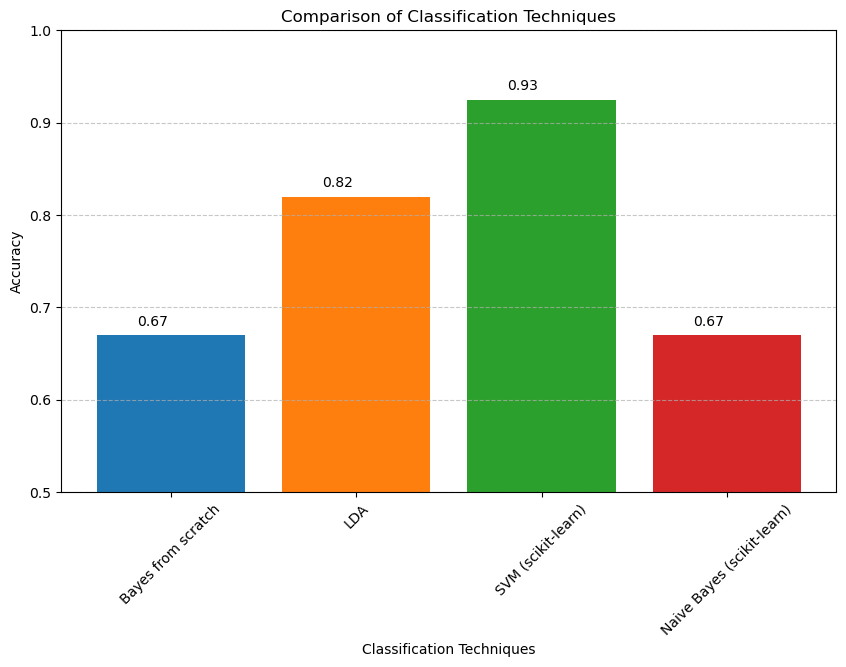

In [40]:
import matplotlib.pyplot as plt

classifiers = ['Bayes from scratch', 'LDA', 'SVM (scikit-learn)', 'Naive Bayes (scikit-learn)']

accuracies = [accuracy, accuracy_lda, accuracy_svm, accuracy_nb]

#Define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

#Plot 
plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color=colors)
plt.xlabel('Classification Techniques')
plt.ylabel('Accuracy')
plt.title('Comparison of Classification Techniques')
plt.ylim(0.5, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)  

#text label
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{accuracy:.2f}', ha='center', color='black')

plt.show()


# Kernel PCA (KPCA)

In [47]:
import pandas as pd
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

#Load the training data
train_data = pd.read_csv("TrainData.csv")

#Separate features and labels
X_train = train_data.iloc[:, :-1]  
y_train = train_data.iloc[:, -1]   

#Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [49]:
#Apply KPCA with different kernels
kernels = ['rbf', 'poly', 'linear']
for kernel in kernels:
    kpca = KernelPCA(kernel=kernel, n_components=10)  # Assuming 10 components
    X_train_kpca = kpca.fit_transform(X_train_scaled)
    
    #Compute explained variance ratio manually
    explained_variance_ratio = np.var(X_train_kpca, axis=0) / np.sum(np.var(X_train_kpca, axis=0))
    print(f"Explained variance ratio for {kernel} kernel:", sum(explained_variance_ratio))
    
    #Store the dimensionality-reduced data to a new CSV file
    reduced_data = pd.DataFrame(X_train_kpca)
    reduced_data.to_csv(f"Reduced_TrainData_{kernel}.csv", index=False)
    print(f"Dimensionality-reduced data for {kernel} kernel stored successfully.")

Explained variance ratio for rbf kernel: 1.0
Dimensionality-reduced data for rbf kernel stored successfully.
Explained variance ratio for poly kernel: 1.0000000000000002
Dimensionality-reduced data for poly kernel stored successfully.
Explained variance ratio for linear kernel: 1.0000000000000002
Dimensionality-reduced data for linear kernel stored successfully.


In [57]:
#test data
test_data = pd.read_csv("TestData.csv")

#Separate features and labels
X_test = test_data.iloc[:, :-1]  
y_test = test_data.iloc[:, -1]   

#Standardize the features
X_test_scaled = scaler.transform(X_test)

#Apply Kernel PCA with different kernels
for kernel in kernels:
    kpca = KernelPCA(kernel=kernel, n_components=10)  # Assuming 10 components
    X_test_kpca = kpca.fit_transform(X_test_scaled)
    
    #Store the dimensionality-reduced data to a new CSV file
    reduced_data = pd.DataFrame(X_test_kpca)
    reduced_data.to_csv(f"Reduced_TestData_{kernel}.csv", index=False)
    print(f"Dimensionality-reduced data for {kernel} kernel stored successfully.")


Dimensionality-reduced data for rbf kernel stored successfully.
Dimensionality-reduced data for poly kernel stored successfully.
Dimensionality-reduced data for linear kernel stored successfully.


In [59]:
import numpy as np

class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = []
        self.labels = y   
        for c in self.classes:
            X_c = X[y == c]
            self.parameters.append([(np.mean(X_c, axis=0), np.var(X_c, axis=0))])
    
    def _calculate_likelihood(self, x, mean, var):
        eps = 1e-4  # to prevent division by zero
        coeff = 1.0 / np.sqrt(2.0 * np.pi * var + eps)
        exponent = np.exp(-(np.square(x - mean) / (2.0 * var + eps)))
        return coeff * exponent
    
    def _calculate_prior(self, c):
        return np.mean(self.labels == c)
    
    def _calculate_posterior(self, x):
        posteriors = []
        for i, c in enumerate(self.classes):
            prior = np.log(self._calculate_prior(c))
            likelihood = np.sum(np.log(self._calculate_likelihood(x, *self.parameters[i][0])))
            posterior = prior + likelihood
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]
    
    def predict(self, X):
        y_pred = [self._calculate_posterior(x) for x in X]
        return np.array(y_pred)

#Instantiate and fit Gaussian Naive Bayes classifier for each kernel
nb_classifier_rbf = GaussianNaiveBayes()
nb_classifier_poly = GaussianNaiveBayes()
nb_classifier_linear = GaussianNaiveBayes()

#Fit Gaussian Naive Bayes classifier for each kernel
nb_classifier_rbf.fit(X_test_reduced_rbf, y_test)
nb_classifier_poly.fit(X_test_reduced_poly, y_test)
nb_classifier_linear.fit(X_test_reduced_linear, y_test)

#Predict labels for dimensionality-reduced test data for each kernel
y_pred_nb_rbf = nb_classifier_rbf.predict(X_test_reduced_rbf)
y_pred_nb_poly = nb_classifier_poly.predict(X_test_reduced_poly)
y_pred_nb_linear = nb_classifier_linear.predict(X_test_reduced_linear)

#Calculate accuracy for each kernel
accuracy_nb_rbf = np.mean(y_pred_nb_rbf == y_test)
accuracy_nb_poly = np.mean(y_pred_nb_poly == y_test)
accuracy_nb_linear = np.mean(y_pred_nb_linear == y_test)

print("Accuracy of Gaussian Naive Bayes classifier on KPCA test data (RBF kernel):", accuracy_nb_rbf)
print("Accuracy of Gaussian Naive Bayes classifier on KPCA test data (Polynomial kernel):", accuracy_nb_poly)
print("Accuracy of Gaussian Naive Bayes classifier on KPCA test data (Linear kernel):", accuracy_nb_linear)


C:\Users\USER\AppData\Local\Temp\ipykernel_3388\770380308.py:25: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self._calculate_likelihood(x, *self.parameters[i][0])))


Accuracy of Gaussian Naive Bayes classifier on KPCA test data (RBF kernel): 0.98
Accuracy of Gaussian Naive Bayes classifier on KPCA test data (Polynomial kernel): 0.98
Accuracy of Gaussian Naive Bayes classifier on KPCA test data (Linear kernel): 0.99


In [60]:
class LinearDiscriminantAnalysis:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = []
        self.covariance = np.zeros((X.shape[1], X.shape[1]))
        self.priors = []
        
        #Calculate class means
        for c in self.classes:
            X_c = X[y == c]
            self.means.append(np.mean(X_c, axis=0))
            self.covariance += np.cov(X_c.T) * (len(X_c) - 1)
            self.priors.append(len(X_c) / len(X))
        
        self.covariance /= len(self.classes)
        self.inv_covariance = np.linalg.inv(self.covariance)
    
    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for i, c in enumerate(self.classes):
                mean = self.means[i]
                prior = self.priors[i]
                posterior = np.log(prior) - 0.5 * np.dot(np.dot((x - mean).T, self.inv_covariance), (x - mean))
                posteriors.append(posterior)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)

#Instantiate and fit LDA classifier for each kernel
lda_classifier_rbf = LinearDiscriminantAnalysis()
lda_classifier_poly = LinearDiscriminantAnalysis()
lda_classifier_linear = LinearDiscriminantAnalysis()

#Fit LDA classifier for each kernel
lda_classifier_rbf.fit(X_test_reduced_rbf, y_test)
lda_classifier_poly.fit(X_test_reduced_poly, y_test)
lda_classifier_linear.fit(X_test_reduced_linear, y_test)

#Predict labels for dimensionality-reduced test data for each kernel
y_pred_lda_rbf = lda_classifier_rbf.predict(X_test_reduced_rbf)
y_pred_lda_poly = lda_classifier_poly.predict(X_test_reduced_poly)
y_pred_lda_linear = lda_classifier_linear.predict(X_test_reduced_linear)

#Calculate accuracy for each kernel
accuracy_lda_rbf = np.mean(y_pred_lda_rbf == y_test)
accuracy_lda_poly = np.mean(y_pred_lda_poly == y_test)
accuracy_lda_linear = np.mean(y_pred_lda_linear == y_test)

print("Accuracy of LDA classifier on KPCA test data (RBF kernel):", accuracy_lda_rbf)
print("Accuracy of LDA classifier on KPCA test data (Polynomial kernel):", accuracy_lda_poly)
print("Accuracy of LDA classifier on KPCA test data (Linear kernel):", accuracy_lda_linear)


Accuracy of LDA classifier on KPCA test data (RBF kernel): 0.945
Accuracy of LDA classifier on KPCA test data (Polynomial kernel): 0.895
Accuracy of LDA classifier on KPCA test data (Linear kernel): 0.95


In [62]:
from sklearn.svm import SVC

#Instantiate SVM classifier for each kernel
svm_classifier_rbf = SVC(kernel='rbf')
svm_classifier_poly = SVC(kernel='poly')
svm_classifier_linear = SVC(kernel='linear')

#Fit SVM classifier for each kernel
svm_classifier_rbf.fit(X_test_reduced_rbf, y_test)
svm_classifier_poly.fit(X_test_reduced_poly, y_test)
svm_classifier_linear.fit(X_test_reduced_linear, y_test)

#Predict labels for dimensionality-reduced test data for each kernel
y_pred_svm_rbf = svm_classifier_rbf.predict(X_test_reduced_rbf)
y_pred_svm_poly = svm_classifier_poly.predict(X_test_reduced_poly)
y_pred_svm_linear = svm_classifier_linear.predict(X_test_reduced_linear)

#Calculate accuracy for each kernel
accuracy_svm_rbf = np.mean(y_pred_svm_rbf == y_test)
accuracy_svm_poly = np.mean(y_pred_svm_poly == y_test)
accuracy_svm_linear = np.mean(y_pred_svm_linear == y_test)

print("Accuracy of SVM classifier on KPCA test data (RBF kernel):", accuracy_svm_rbf)
print("Accuracy of SVM classifier on KPCA test data (Polynomial kernel):", accuracy_svm_poly)
print("Accuracy of SVM classifier on KPCA test data (Linear kernel):", accuracy_svm_linear)


Accuracy of SVM classifier on KPCA test data (RBF kernel): 0.925
Accuracy of SVM classifier on KPCA test data (Polynomial kernel): 0.73
Accuracy of SVM classifier on KPCA test data (Linear kernel): 1.0


In [64]:
from sklearn.naive_bayes import GaussianNB

#Instantiate Naive Bayes classifier for each kernel
nb_classifier_rbf = GaussianNB()
nb_classifier_poly = GaussianNB()
nb_classifier_linear = GaussianNB()

#Fit Naive Bayes classifier for each kernel
nb_classifier_rbf.fit(X_test_reduced_rbf, y_test)
nb_classifier_poly.fit(X_test_reduced_poly, y_test)
nb_classifier_linear.fit(X_test_reduced_linear, y_test)

#Predict labels for dimensionality-reduced test data for each kernel
y_pred_nb_rbf = nb_classifier_rbf.predict(X_test_reduced_rbf)
y_pred_nb_poly = nb_classifier_poly.predict(X_test_reduced_poly)
y_pred_nb_linear = nb_classifier_linear.predict(X_test_reduced_linear)

#Calculate accuracy for each kernel
accuracy_nb_rbf = np.mean(y_pred_nb_rbf == y_test)
accuracy_nb_poly = np.mean(y_pred_nb_poly == y_test)
accuracy_nb_linear = np.mean(y_pred_nb_linear == y_test)

print("Accuracy of Naive Bayes classifier on KPCA test data (RBF kernel):", accuracy_nb_rbf)
print("Accuracy of Naive Bayes classifier on KPCA test data (Polynomial kernel):", accuracy_nb_poly)
print("Accuracy of Naive Bayes classifier on KPCA test data (Linear kernel):", accuracy_nb_linear)


Accuracy of Naive Bayes classifier on KPCA test data (RBF kernel): 0.98
Accuracy of Naive Bayes classifier on KPCA test data (Polynomial kernel): 0.98
Accuracy of Naive Bayes classifier on KPCA test data (Linear kernel): 0.99


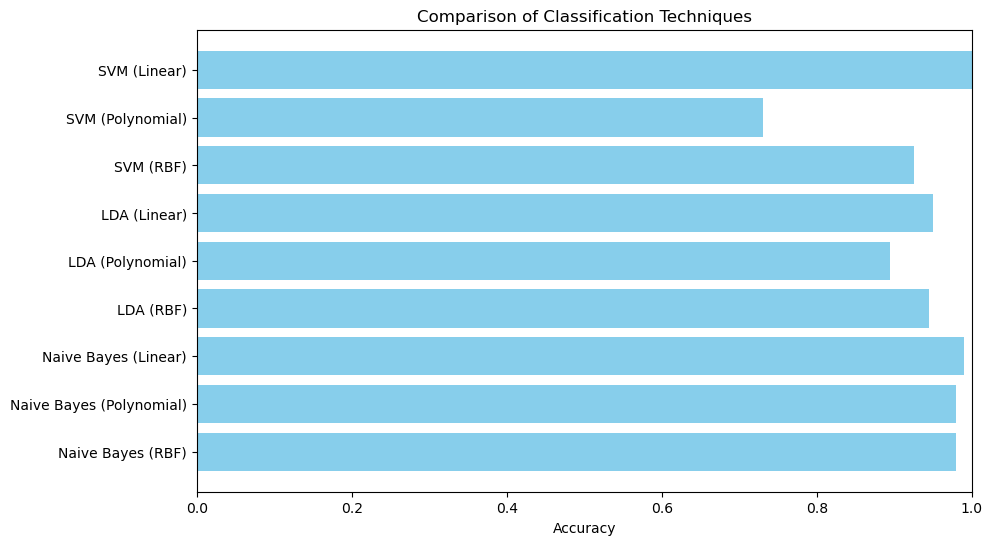

In [65]:
import matplotlib.pyplot as plt

#Defining accuracies for each classifier and kernel
accuracies = {
    "Naive Bayes (RBF)": accuracy_nb_rbf,
    "Naive Bayes (Polynomial)": accuracy_nb_poly,
    "Naive Bayes (Linear)": accuracy_nb_linear,
    "LDA (RBF)": accuracy_lda_rbf,
    "LDA (Polynomial)": accuracy_lda_poly,
    "LDA (Linear)": accuracy_lda_linear,
    "SVM (RBF)": accuracy_svm_rbf,
    "SVM (Polynomial)": accuracy_svm_poly,
    "SVM (Linear)": accuracy_svm_linear
}

#Plotting
plt.figure(figsize=(10, 6))
plt.barh(list(accuracies.keys()), list(accuracies.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.title('Comparison of Classification Techniques')
plt.xlim(0, 1)  # Set x-axis limit to 0-1 for accuracy
plt.show()


# PCA vs KPCA 

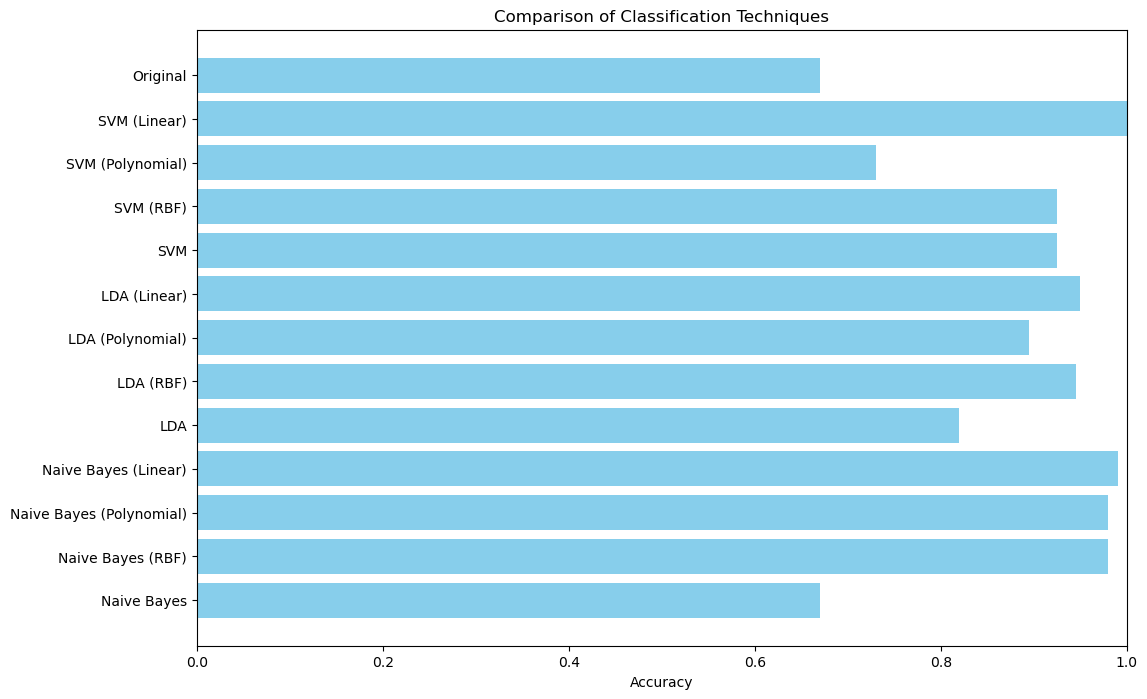

In [66]:
#Define accuracies for each classifier and kernel
accuracies = {
    "Naive Bayes": accuracy_nb,
    "Naive Bayes (RBF)": accuracy_nb_rbf,
    "Naive Bayes (Polynomial)": accuracy_nb_poly,
    "Naive Bayes (Linear)": accuracy_nb_linear,
    "LDA": accuracy_lda,
    "LDA (RBF)": accuracy_lda_rbf,
    "LDA (Polynomial)": accuracy_lda_poly,
    "LDA (Linear)": accuracy_lda_linear,
    "SVM": accuracy_svm,
    "SVM (RBF)": accuracy_svm_rbf,
    "SVM (Polynomial)": accuracy_svm_poly,
    "SVM (Linear)": accuracy_svm_linear,
    "Original": accuracy
}

#Plotting
plt.figure(figsize=(12, 8))
plt.barh(list(accuracies.keys()), list(accuracies.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.title('Comparison of Classification Techniques')
plt.xlim(0, 1)  # Set x-axis limit to 0-1 for accuracy
plt.show()


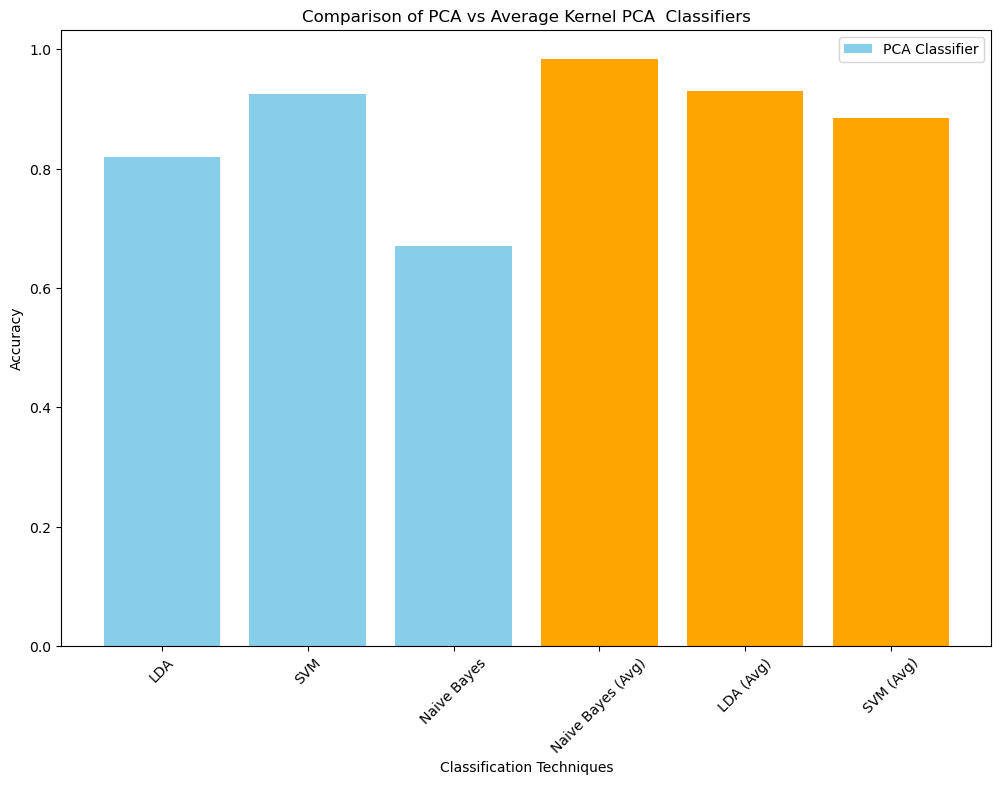

In [70]:
#Define original accuracies and average KPCA accuracies
original_accuracies = {
    "LDA": accuracy_lda,
    "SVM": accuracy_svm,
    "Naive Bayes": accuracy_nb
}

average_kpca_accuracies = {
    "Naive Bayes (Avg)": average_nb,
    "LDA (Avg)": average_lda,
    "SVM (Avg)": average_svm
}

#Concatenate the labels
labels = list(original_accuracies.keys()) + list(average_kpca_accuracies.keys())

#Convert accuracies to lists for plotting
values = list(original_accuracies.values()) + list(average_kpca_accuracies.values())

#Plotting the grouped bar graph
bar_width = 0.35
index = np.arange(len(labels))

plt.figure(figsize=(12, 8))
plt.bar(index, values, color=['skyblue'] * len(original_accuracies) + ['orange'] * len(average_kpca_accuracies))
plt.xlabel('Classification Techniques')
plt.ylabel('Accuracy')
plt.title('Comparison of PCA vs Average Kernel PCA  Classifiers')
plt.xticks(index, labels, rotation=45)
plt.legend(['PCA Classifier', 'KPCA (Average)'])
plt.show()


To summarize the influence of PCA and KPCA on Naive Bayes, SVM, and LDA classifiers:

Naive Bayes Classifier:
PCA: PCA simplifies the feature space, making it suitable for Naive Bayes classifiers. It reduces computational complexity and improves efficiency.
KPCA: KPCA captures nonlinear relationships, potentially enhancing the Naive Bayes classifier's performance on datasets with complex structures. However, it may increase computational overhead.


Support Vector Machine (SVM) Classifier:
PCA: PCA can improve SVM classifier performance by reducing feature dimensionality and mitigating the curse of dimensionality. It simplifies the decision boundary and speeds up computation.
KPCA: KPCA allows SVM classifiers to capture nonlinear relationships, enabling better separation of classes in complex datasets. However, it may lead to longer training times due to increased computational complexity.


Linear Discriminant Analysis (LDA) Classifier:
PCA: PCA can complement LDA by preprocessing data to remove noise and reduce dimensionality. It helps improve LDA's performance by enhancing data separability and reducing overfitting.
KPCA: KPCA provides an alternative to PCA when dealing with nonlinear data. It allows LDA classifiers to handle complex datasets with nonlinear relationships, potentially leading to better classification performance.


In summary, both PCA and KPCA can positively influence the performance of Naive Bayes, SVM, and LDA classifiers by reducing dimensionality and capturing relevant features. PCA is suitable for linear relationships and simpler datasets, while KPCA is advantageous for capturing nonlinear relationships and handling complex datasets. The choice between PCA and KPCA depends on the dataset's characteristics and the classifier's requirements.

Evaluation and Analysis:

PCA vs. KPCA with Image Datasets:
PCA is effective for linear dimensionality reduction in image datasets, where features may have linear relationships.
KPCA, on the other hand, is advantageous for capturing nonlinear relationships inherent in image data, allowing for better feature representation and improved classifier performance.
While PCA simplifies the feature space and reduces computational complexity, KPCA provides more flexibility in handling complex image structures but requires more computational resources.


From Scratch vs. Scikit-learn Classifiers with Image Datasets:
Implementing classifiers from scratch offers a deeper understanding of algorithmic concepts and allows for customization to suit specific image data characteristics.
However, for image datasets, where complex patterns and relationships exist, using Scikit-learn classifiers saves time and effort. Scikit-learn classifiers are optimized for image data processing, offering efficient and scalable solutions.
While implementing classifiers from scratch provides control and customization, it can be challenging and time-consuming, especially for complex image datasets.


PCA vs. KPCA with Classifiers on Image Datasets:
PCA with classifiers simplifies image feature representations, making them suitable for linear classifiers and improving computational efficiency.
On the other hand, KPCA with classifiers allows for capturing nonlinear patterns in image data, enhancing classifier performance on complex image datasets.
Choosing between PCA and KPCA depends on the nature of the image dataset: PCA is suitable for simpler, linear relationships, while KPCA is preferable for datasets with intricate, nonlinear structures.


In conclusion, when working with image datasets, KPCA with Scikit-learn classifiers proves beneficial for capturing and leveraging nonlinear relationships, leading to improved classification performance. While implementing classifiers from scratch offers control and customization, Scikit-learn classifiers provide efficiency and scalability, making them preferable choices for image data processing tasks. Additionally, understanding the trade-offs between PCA and KPCA is crucial, as their suitability depends on the complexity of the image dataset's underlying structures.